In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX,SARIMAXResults
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing dataset
df = pd.read_csv('Walmart DataSet.csv')
# Setting date column as index
df.index = pd.to_datetime(df.Date,dayfirst=True)
# Dropping the date column
df.drop(columns='Date',inplace=True)
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
# Cheking last date of dataset
df.tail()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2012-09-28,45,713173.95,0,64.88,3.997,192.013558,8.684
2012-10-05,45,733455.07,0,64.89,3.985,192.170412,8.667
2012-10-12,45,734464.36,0,54.47,4.000,192.327265,8.667
2012-10-19,45,718125.53,0,56.47,3.969,192.330854,8.667
2012-10-26,45,760281.43,0,58.85,3.882,192.308899,8.667


In [4]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


In [5]:
# Null value analysis
df.isnull().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [6]:
# Counting number of stores
print('There are',df.Store.nunique(),'Stores inside the dataset')

There are 45 Stores inside the dataset


Let's check trend of average sales

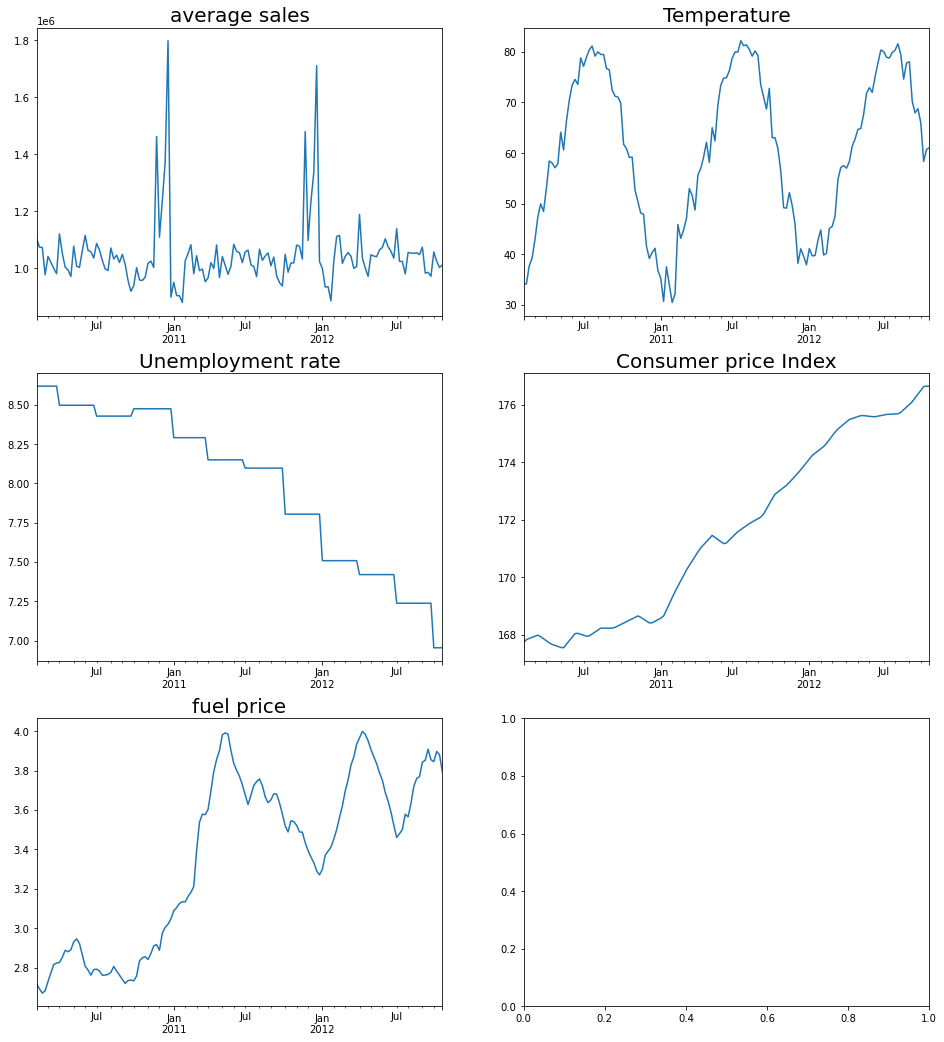

In [7]:
# capturing date wise parameters change
week_wise_data = df.groupby('Date')[df.columns].mean()

plt.subplots(3,2,figsize=(16,18))

plt.subplot(3,2,1)
week_wise_data.Weekly_Sales.plot()
plt.title('average sales',fontsize=20)
plt.xlabel('')

plt.subplot(3,2,2)
week_wise_data.Temperature.plot()
plt.title('Temperature',fontsize=20)
plt.xlabel('')

plt.subplot(3,2,3)
week_wise_data.Unemployment.plot()
plt.title('Unemployment rate',fontsize=20)
plt.xlabel('')

plt.subplot(3,2,4)
week_wise_data.CPI.plot()
plt.title('Consumer price Index',fontsize=20)
plt.xlabel('')

plt.subplot(3,2,5)
week_wise_data.Fuel_Price.plot()
plt.title('fuel price',fontsize=20)
plt.xlabel('')
plt.show()

#### Observations:
1. Over the year `average sales` doesn't change.(Trend = 0)
2. In Dec-Jan (winter) sales are very high. (Strong Seasonality)
3. `Unemployment` has negative trend.
4. `CPI` and `fuel price` has posetive trend.

In [8]:
df['Rate of change of Unemployment'] = df['Unemployment'] - df['Unemployment'].shift(1)
df['Rate of change of CPI'] = df['CPI'] - df['CPI'].shift(1)
df['Rate of change of Fuel_Price'] = df['Fuel_Price'] - df['Fuel_Price'].shift(1)
df.drop('2010-02-05',axis=0,inplace=True)

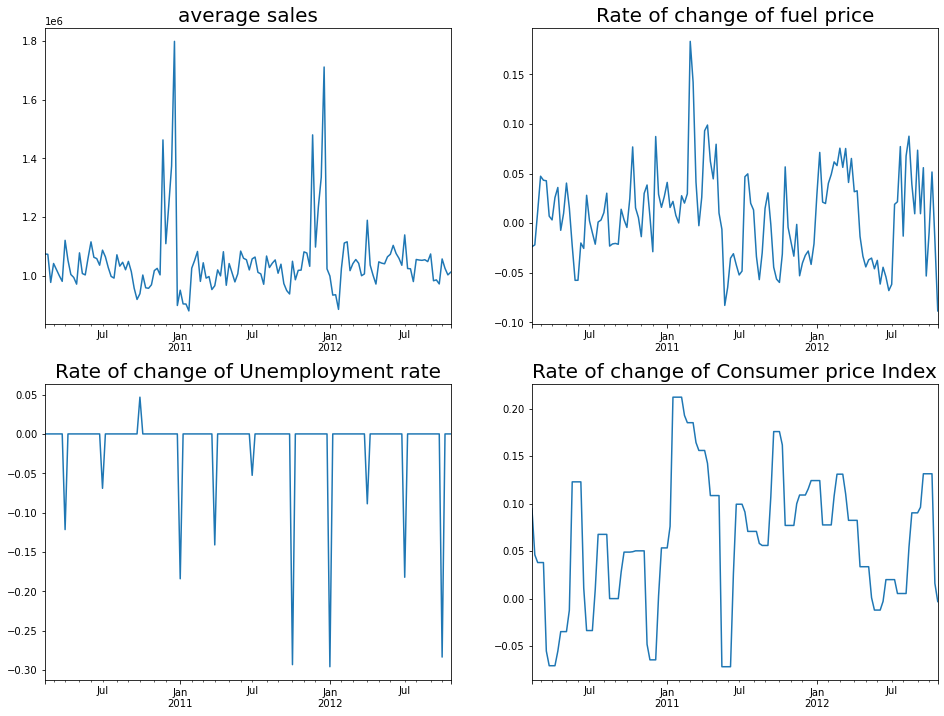

In [9]:
# capturing date wise parameters change
week_wise_data = df.groupby('Date')[df.columns].mean()

plt.subplots(2,2,figsize=(16,12))

plt.subplot(2,2,1)
week_wise_data.Weekly_Sales.plot()
plt.title('average sales',fontsize=20)
plt.xlabel('')

plt.subplot(2,2,2)
week_wise_data['Rate of change of Fuel_Price'].plot()
plt.title('Rate of change of fuel price',fontsize=20)
plt.xlabel('')

plt.subplot(2,2,3)
week_wise_data['Rate of change of Unemployment'].plot()
plt.title('Rate of change of Unemployment rate',fontsize=20)
plt.xlabel('')

plt.subplot(2,2,4)
week_wise_data['Rate of change of CPI'].plot()
plt.title('Rate of change of Consumer price Index',fontsize=20)
plt.xlabel('')
plt.show()

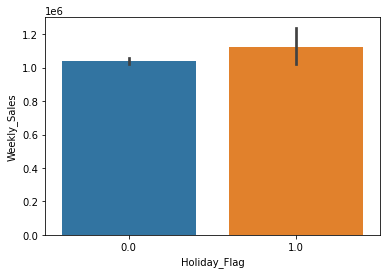

In [10]:
# plotting weekly sales value on businessday and holidays
sns.barplot(y='Weekly_Sales',x='Holiday_Flag',data=week_wise_data)
plt.show()

**Average sales on businessday and holiday are almost same.**

**Let's check correlation among the parameters.**

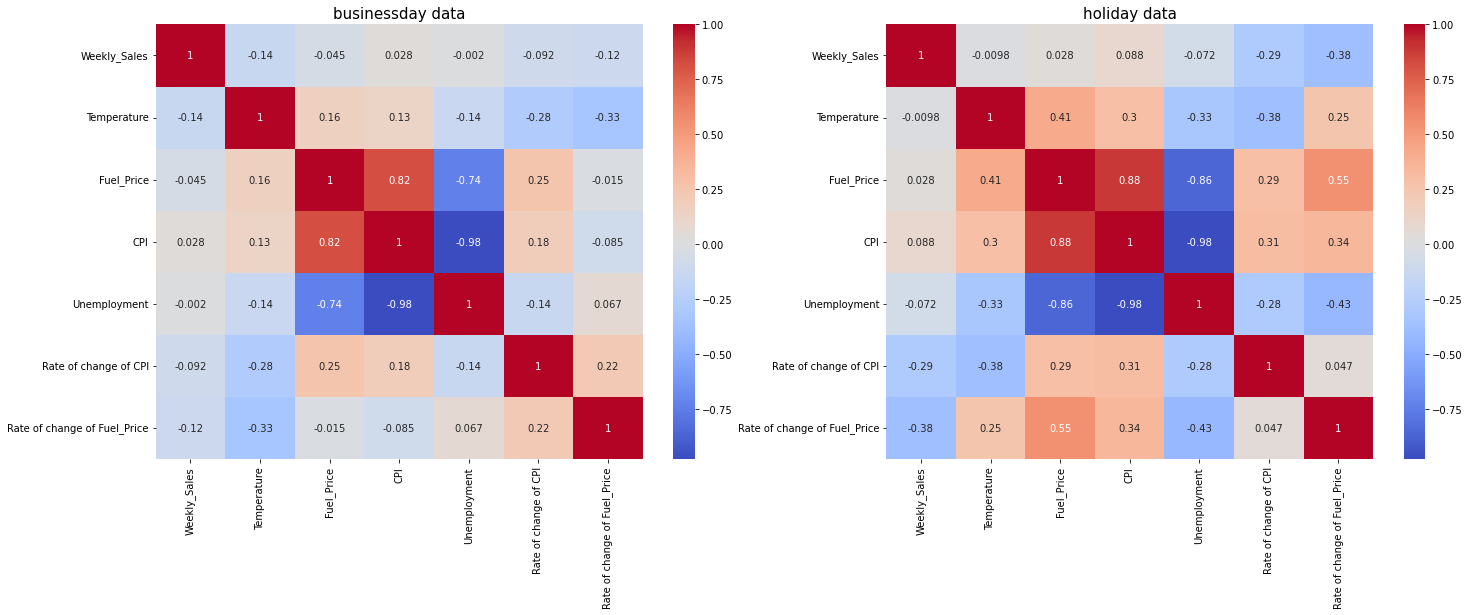

In [11]:
data = week_wise_data.drop('Rate of change of Unemployment',axis=1)
# Seperating businessday and holiday data and plotting
data_businessday = data[data.Holiday_Flag==0].drop(columns='Holiday_Flag')
data_holiday = data[data.Holiday_Flag==1].drop(columns='Holiday_Flag')
plt.subplots(1,2,figsize=(24,8))

plt.subplot(1,2,1)
sns.heatmap(data_businessday.drop(columns='Store').corr(),annot=True,cmap='coolwarm')
plt.title('businessday data',fontsize=15)
plt.subplot(1,2,2)
sns.heatmap(data_holiday.drop(columns='Store').corr(),annot=True,cmap='coolwarm')
plt.title('holiday data',fontsize=15)
plt.show()

`Unemployment` rate has strong negative correlation with `CPI` and `Fuel_price`. This is because all 3 datas are not stationary and this relation may be a **`spurious correlation`**.

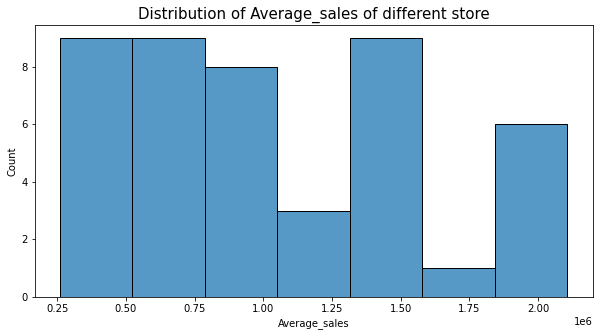

In [12]:
store_wise_sales = np.round(df.groupby('Store').agg(Average_sales=('Weekly_Sales','mean')),0).sort_values(by='Average_sales',ascending=False)
plt.figure(figsize=(10,5))
sns.histplot(store_wise_sales['Average_sales'])
plt.title('Distribution of Average_sales of different store',fontsize=15)
plt.show()

In [13]:
# Getting Top-5 Stores
store_wise_sales.head()

,Average_sales
Store,
20,2105608.0
4,2094428.0
14,2016736.0
13,2003877.0
2,1924264.0


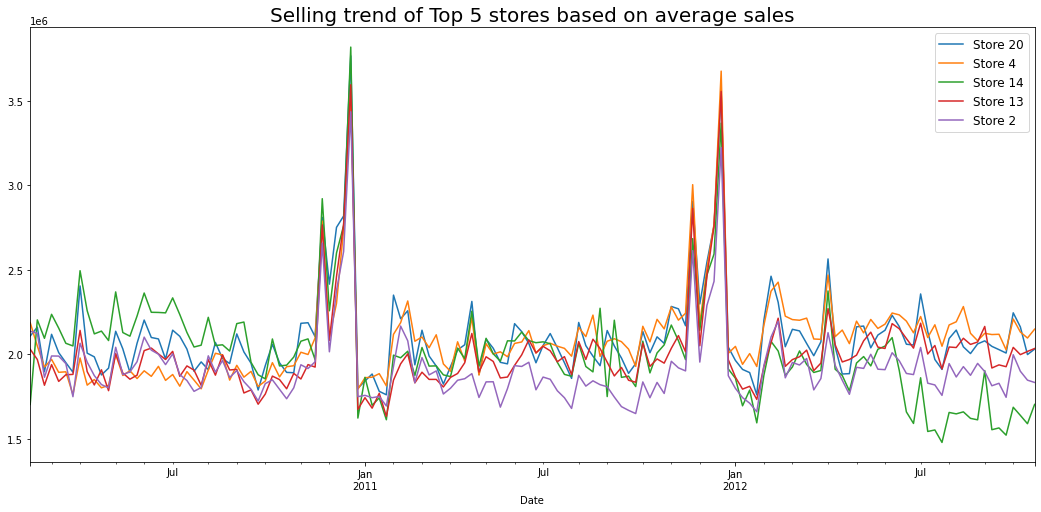

In [14]:
# Plotting Selling trend of Top-5 companies
plt.figure(figsize=(18,8))
for store_num in store_wise_sales.index[:5]:
    df[df.Store==store_num].Weekly_Sales.plot(label=f'Store {store_num}')
plt.legend(fontsize=12)
plt.title('Selling trend of Top 5 stores based on average sales',fontsize=20)
plt.show()

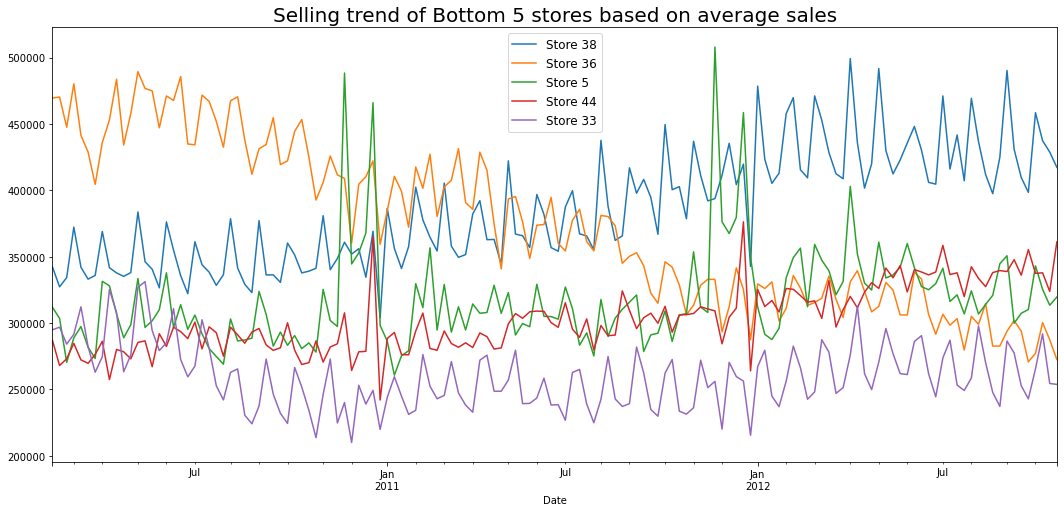

In [15]:
# Plotting Selling trend of Bottom-5 companies
plt.figure(figsize=(18,8))
for store_num in store_wise_sales.index[-5:]:
    df[df.Store==store_num].Weekly_Sales.plot(label=f'Store {store_num}')
plt.legend(fontsize=12)
plt.title('Selling trend of Bottom 5 stores based on average sales',fontsize=20)
plt.show()

### Observing how temperature, CPI and Unemployment rate impacts Weekly_Sales

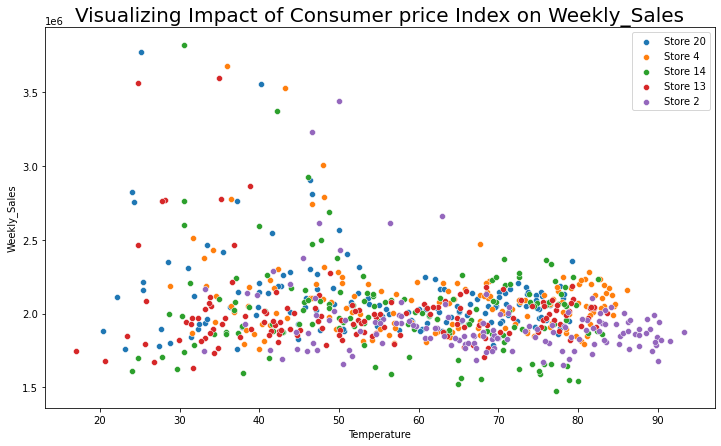

In [32]:
plt.figure(figsize=(12,7))
for store_num in store_wise_sales.index[:5]:
    sns.scatterplot(x='Temperature',y='Weekly_Sales',data=df[df.Store==store_num],label=f'Store {store_num}')
plt.title('Visualizing Impact of Temperature on Weekly_Sales',fontsize=20)
plt.show()

Sales is getting little increased at temperature between $20-50^o F$

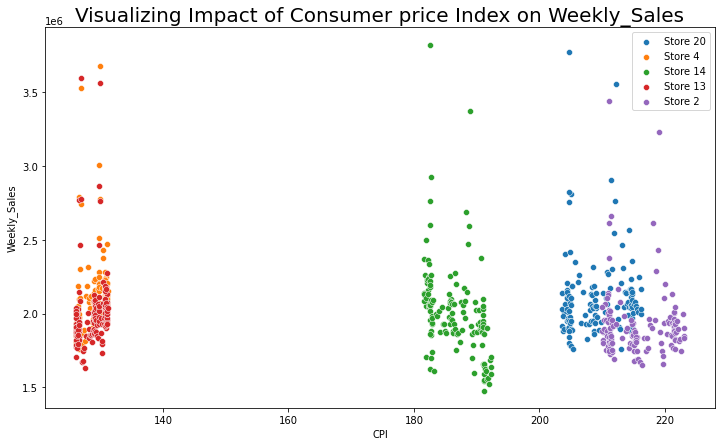

In [16]:
plt.figure(figsize=(12,7))
for store_num in store_wise_sales.index[:5]:
    sns.scatterplot(x='CPI',y='Weekly_Sales',data=df[df.Store==store_num],label=f'Store {store_num}')
plt.title('Visualizing Impact of Consumer price Index on Weekly_Sales',fontsize=20)
plt.show()

No relation between `CPI` and `Weekly_Sales`

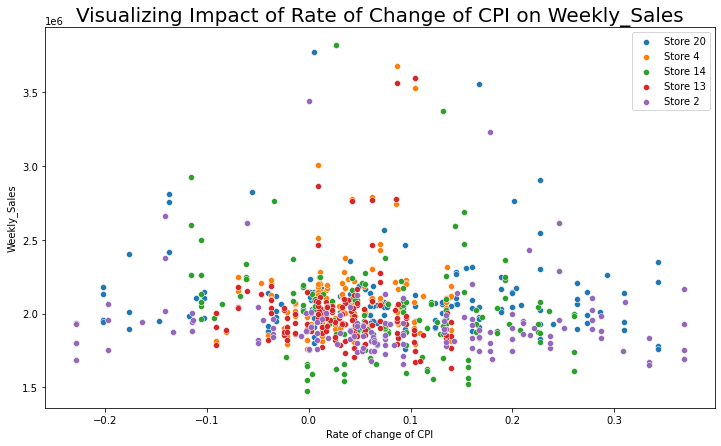

In [17]:
plt.figure(figsize=(12,7))
for store_num in store_wise_sales.index[:5]:
    sns.scatterplot(x='Rate of change of CPI',y='Weekly_Sales',data=df[df.Store==store_num],label=f'Store {store_num}')
plt.title('Visualizing Impact of Rate of Change of CPI on Weekly_Sales',fontsize=20)
plt.show()

No relation between `Rate of Change of CPI` and `Weekly_Sales`

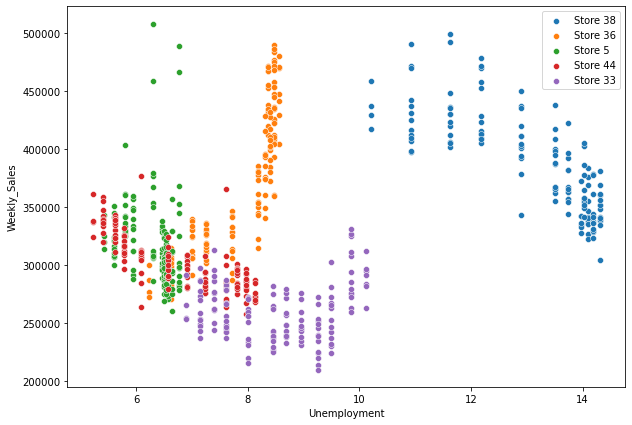

In [18]:
plt.figure(figsize=(10,7))
for store_num in store_wise_sales.index[-5:]:
    sns.scatterplot(x='Unemployment',y='Weekly_Sales',data=df[df.Store==store_num],label=f'Store {store_num}')
plt.show()

No relation between `Unemployment rate` and `Weekly_Sales`

### Forecasting sales of a particular store for example Store No. 5

In [19]:
# Fetching detail of Store No. 5 and saving in different DataFrame
df_5 = df[df.Store==5]

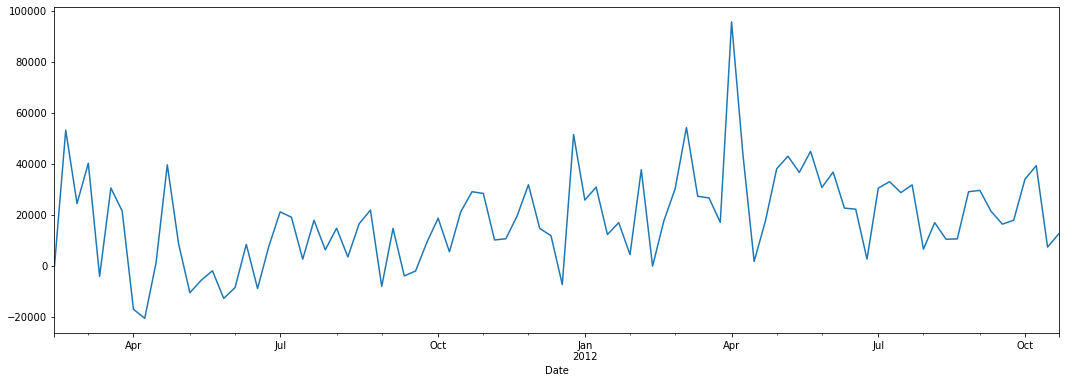

In [20]:
# Plotting trend of Store No. 5
df_5['Sales shift-52'] = df_5['Weekly_Sales'] - df_5['Weekly_Sales'].shift(52)
df_5['Sales shift-52'].dropna().plot(figsize=(18,6))
plt.show()

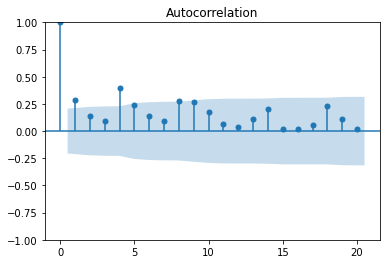

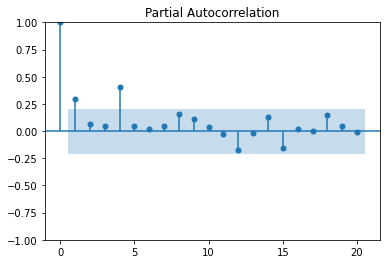

In [21]:
# ACF and PACF plot
plot_acf(df_5['Sales shift-52'].dropna());
plot_pacf(df_5['Sales shift-52'].dropna());

In [22]:
# Let's check which model is best
order = auto_arima(df_5['Sales shift-52'].dropna(), trace=True)
order.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1999.738, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2035.493, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2023.901, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1999.271, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2033.503, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2001.571, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1998.435, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2000.403, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2007.365, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2001.816, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1995.850, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1994.746, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1996.193, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2021.821, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -995.373
Date:                Wed, 04 Jan 2023   AIC                           1994.746
Time:                        00:16:24   BIC                           1999.724
Sample:                    02-11-2011   HQIC                          1996.753
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8643      0.060    -14.461      0.000      -0.981      -0.747
sigma2       3.07e+08   1.83e-11   1.68e+19      0.000    3.07e+08    3.07e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                31.96
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.76
Prob(H) (two-sided):                  0.99   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

### Model building

In [23]:
# train-test split
train_end_date = pd.to_datetime('2012-08-10')
train_data = df_5[:train_end_date].copy()

# model building
mod = sm.tsa.statespace.SARIMAX(train_data['Weekly_Sales'],
                                order=(0,1,1),
                                seasonal_order=(0, 1, 0, 52))
                                 
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2361      0.041     -5.830      0.000      -0.316      -0.157
sigma2      3.299e+08   4.78e-12   6.91e+19      0.000     3.3e+08     3.3e+08


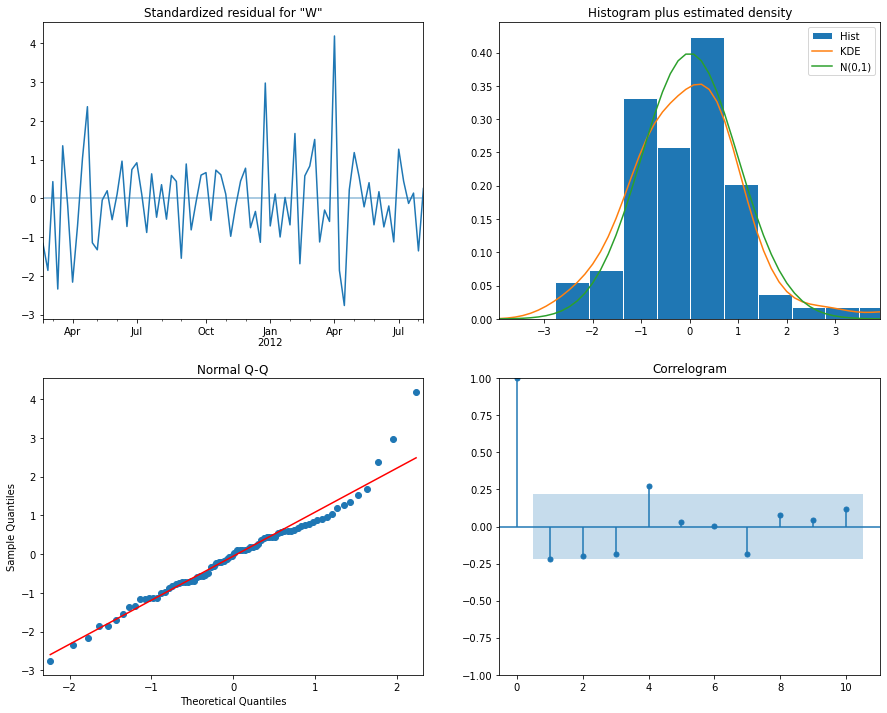

In [24]:
# Plotting distribution of residuals
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [25]:
#forecasting 24 weeks ahed in future
forecast = results.get_forecast(steps=24)
# Confidence Interval of forecasting
pred_ci = forecast.conf_int()

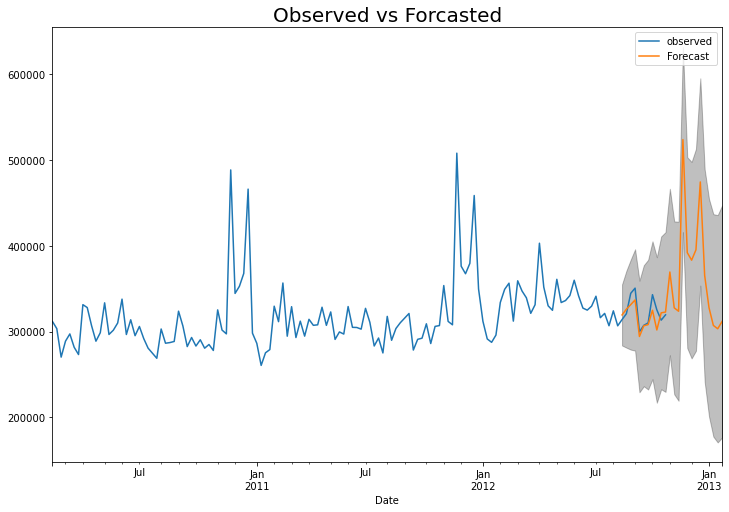

In [26]:
# Plotting the data
ax = df_5.Weekly_Sales.plot(label='observed', figsize=(12, 8))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Observed vs Forcasted',fontsize=20)
plt.legend()
plt.show()